In [310]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [311]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

surprise has 249 number of images
fear has 75 number of images
sadness has 84 number of images
happy has 207 number of images
anger has 135 number of images


`sadness` and `fear` has very low number of images as compared to other classes

In [312]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

### Data Preprocessing

I first make the data compatible for neural nets

In [313]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [314]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [315]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [316]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

surprise has 83 samples
fear has 25 samples
sadness has 28 samples
happy has 69 samples
anger has 45 samples


In [317]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

X.shape, y.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((250, 3, 48, 48, 1), (250, 5))

In [318]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [319]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True, random_state=42)
X_train.shape, X_valid.shape

((175, 3, 48, 48, 1), (75, 3, 48, 48, 1))

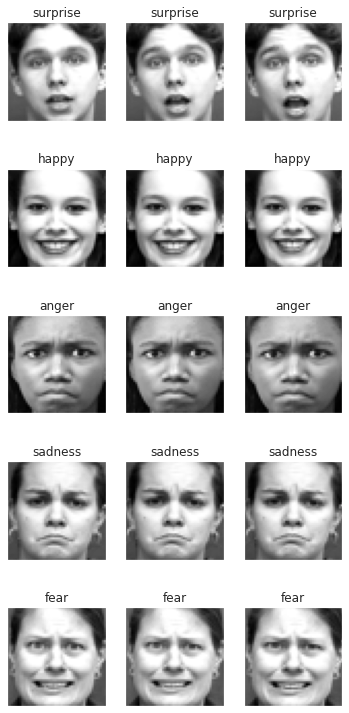

In [320]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [321]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [322]:
def build_dcnn(input_shape, show_arch=True):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [323]:
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [324]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 32
epochs = 100

In [325]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 3, 512)            4691904   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 3, 256)            656384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None,

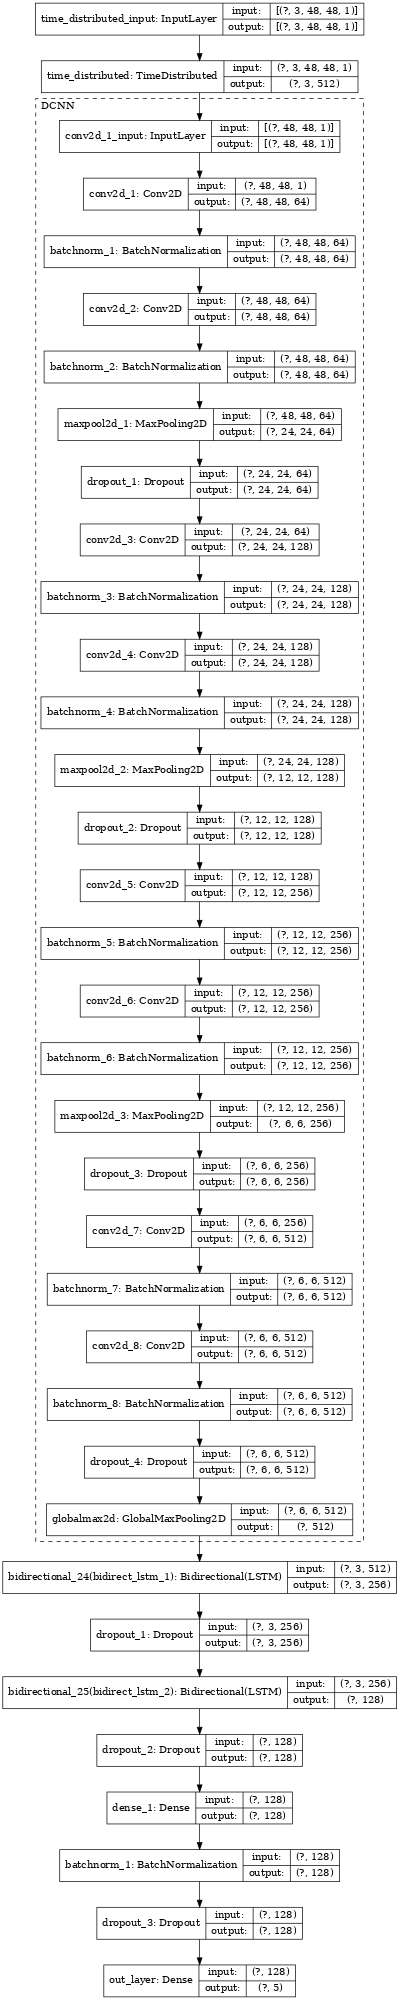

In [326]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')

In [328]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train on 175 samples, validate on 75 samples
Epoch 1/100
175/175 [==============================] - 10s 57ms/sample - loss: 3.0146 - accuracy: 0.2400 - val_loss: 1.5646 - val_accuracy: 0.3333
Epoch 2/100
175/175 [==============================] - 0s 2ms/sample - loss: 2.9973 - accuracy: 0.1886 - val_loss: 1.5232 - val_accuracy: 0.3467
Epoch 3/100
175/175 [==============================] - 0s 2ms/sample - loss: 2.9063 - accuracy: 0.2800 - val_loss: 1.5368 - val_accuracy: 0.3067
Epoch 4/100
175/175 [==============================] - 0s 2ms/sample - loss: 3.4395 - accuracy: 0.1486 - val_loss: 1.5220 - val_accuracy: 0.3333
Epoch 5/100
175/175 [==============================] - 0s 2ms/sample - loss: 2.6883 - accuracy: 0.2400 - val_loss: 1.5306 - val_accuracy: 0.3333
Epoch 6/100
175/175 [==============================] - 0s 2ms/sample - loss: 3.2689 - accuracy: 0.2171 - val_loss: 1.5206 - val_accuracy: 0.3600
Epoch 7/100
175/175 [==============================] - 0s 2ms/sample - loss: 2.6840

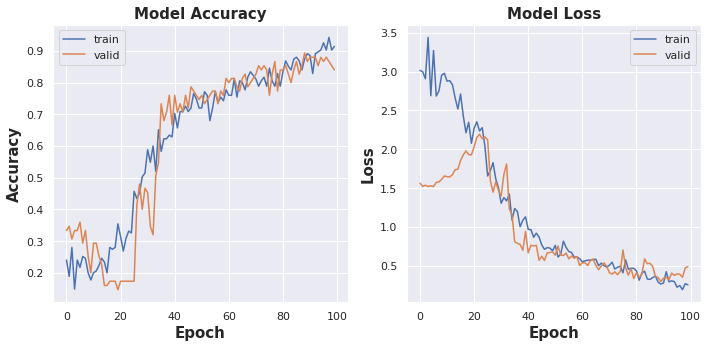

In [329]:
sns.set()
fig = pyplot.figure(0, (10,5))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Model Accuracy', fontsize = 15, fontweight=1000)
pyplot.xlabel('Epoch', fontsize = 15, fontweight=700)
pyplot.ylabel('Accuracy', fontsize = 15, fontweight=700)
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Model Loss', fontsize = 15, fontweight=1000)
pyplot.xlabel('Epoch', fontsize = 15, fontweight=700)
pyplot.ylabel('Loss', fontsize = 15, fontweight=700)
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [331]:
y_pred = model.predict(X_valid)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[0, 3, 3, 2, 4, 1, 0, 1, 0, 0]

In [332]:
y_actual = []

for pred in y_valid:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[0, 3, 3, 2, 4, 1, 0, 1, 0, 0]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.84      1.00      0.91        21
           2       0.65      1.00      0.79        13
           3       0.75      0.38      0.50         8
           4       1.00      0.25      0.40         8

    accuracy                           0.84        75
   macro avg       0.85      0.72      0.72        75
weighted avg       0.87      0.84      0.81        75



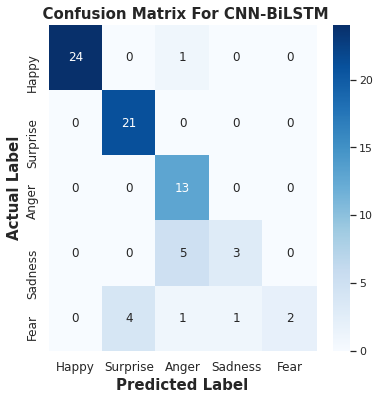

In [333]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

pyplot.figure(figsize = (6,6))
ax = pyplot.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Happy", "Surprise", "Anger", "Sadness", "Fear"], fontsize=12);
ax.yaxis.set_ticklabels([  "Happy", "Surprise", "Anger", "Sadness", "Fear"],  fontsize=12);

pyplot.title('  Confusion Matrix For CNN-BiLSTM ', fontsize = 15, fontweight=1000)
pyplot.xlabel('Predicted Label', fontsize = 15, fontweight=1000)
pyplot.ylabel('Actual Label', fontsize = 15, fontweight=1000)


pyplot.savefig("Confusion Matrix")